<a href="https://colab.research.google.com/github/arnisafazla/CS490/blob/main/490_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
sys.path.append('/content/drive/My Drive/CS490')
sys.path.insert(0,'/content/drive/MyDrive/CS490/PyMO')

Mounted at /content/drive


In [5]:
%load /content/drive/MyDrive/CS490/PyMO/pymo/viz_tools.py
%load /content/drive/MyDrive/CS490/PyMO/pymo/parsers.py
%load /content/drive/MyDrive/CS490/PyMO/pymo/data.py
%load /content/drive/MyDrive/CS490/PyMO/pymo/viz_tools.py
%load /content/drive/MyDrive/CS490/PyMO/pymo/preprocessing.py
%load_ext tensorboard
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import backend as K
import datetime, os
from tensorflow.keras import layers
from tensorflow.keras import utils
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import json
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import pymo.parsers as parsers
import pymo.viz_tools as viz_tools
import pymo.preprocessing as preprocessing
import pymo.data as mocapdata

In [122]:
from threading import RLock
# using PyMO, raw data for each emotion. do anger and joy for now.
# you don't keep pymo parsers. How visualize etc the data from pos and rotation values??

# do more preprocessing and data augmentation
class Dataset(object):
  def __init__(
                self, 
                emotions,
                step_size = 10,
                # path to drive will be constant, go to the folder named the emotion and load all the files in it.
                path = '/content/drive/MyDrive/CS490/dataset',
                frames = 200
    ):
    self.emotions = np.array(emotions).reshape((-1))
    self.step_size = step_size
    self.onehotencoder = OneHotEncoder()
    self.onehotencoder.fit_transform(self.emotions.reshape(-1,1))
    # to encode: self.onehotencoder.transform([['joy']]).toarray().reshape((-1))
    # to decode: self.onehotencoder.inverse_transform([[1,0,0]])

    self.ordinalencoder = OrdinalEncoder()
    self.ordinalencoder.fit_transform(self.emotions.reshape((-1,1)))
    # to encode: self.ordinalencoder.transform(emotions.reshape((-1,1)))
    # to decode: self.ordinalencoder.inverse_transform([[2]])

    self.Y_vec = []
    self.X = []
    self.Y_ord = []
    # self.data = []  # list of MocapData
    self.data = mocapdata.MocapData()
    self.feature_names = []  
    self.position_features = ['Hips_Xposition', 'Hips_Yposition', 'Hips_Zposition']
    self.path = path
    self.frames = frames
    self.__load_data__()

  def __load_data__(self):
    parser = parsers.BVHParser()
    for emotion in self.emotions:
      data_path = self.path + '/' + str(emotion)
      file_names = os.listdir(data_path)
      one_hot_encoded_emotion = self.onehotencoder.transform([[emotion]]).toarray().reshape((-1))
      ordinal_encoded_emotion = self.ordinalencoder.transform([[emotion]]).reshape((-1))
      for file_name in file_names:
        file_path = data_path + '/' + file_name
        parser.parse(file_path)    
        length = len(parser.data.values)
        no_of_parts = (length - self.frames) // self.step_size
        for i in range(no_of_parts):
          sample = parser.data.values[i * self.step_size:i * self.step_size + self.frames]
          """
          data = parser.data.clone()
          data.values = sample
          self.data.append(data)   # to be able to use the PyMO library
          """
          # apply sin and arcsin for rotation data for now
          self.X.append(np.array(sample.drop(columns=self.position_features)))

          self.Y_vec.append(one_hot_encoded_emotion)
          self.Y_ord.append(ordinal_encoded_emotion)

    self.data = parser.data
    self.feature_names = parser.data.values.columns   #.drop(self.position_features)
    self.X = np.array(self.X)
    self.Y_vec = np.array(self.Y_vec)
    self.Y_ord = np.array(self.Y_ord)

  def train_test_split(self, test_size = 0.33, shuffle = True, ord = False):
    # X_train, X_test, Y_train, Y_test = train_test_split(self.X, self.Y, test_size=test_size, random_state=42, shuffle=shuffle)
    size = self.X.shape[0]
    index = [*range(size)]
    random.shuffle(index)
    data_shuffled = np.array([self.data[i] for i in index])
    X_shuffled = np.array([self.X[i] for i in index])
    if ord:
      Y_shuffled = np.array([self.Y_ord[i] for i in index])
    else:
      Y_shuffled = np.array([self.Y_vec[i] for i in index])
    
    split = size - int(size * test_size)
    return X_shuffled[0:split], Y_shuffled[0:split], X_shuffled[split:], Y_shuffled[split:]
    # return X_train, Y_train, X_test, Y_test

  # select real samples
  def generate_real_samples(self, n_samples):
    # split into seq and labels
    seq, labels = self.X, self.Y_ord
    # choose random instances
    seq = np.concatenate([seq, np.zeros((seq.shape[0], seq.shape[1], 3))], axis=2)
    r = np.random.randint(0, seq.shape[0], n_samples)
    # select seq and labels
    X, labels = seq[r]/180, labels[r] 
    # scale from [-180,180] to [-1,1] by dividing to 180.
    # generate class labels
    y = np.ones((n_samples, 1))
    return [X, labels], y

  def generate_fake_samples(self, n_samples):
    # split into seq and labels
    seq, labels = self.X, self.Y_ord
    # choose random instances
    rx = np.random.randint(0, seq.shape[0], n_samples)
    rl = np.random.randint(0, seq.shape[0], n_samples)
    # select seq and labels
    X = seq[rx]/180
    labels_tmp = labels[rl]
    # scale from [-180,180] to [-1,1] by dividing to 180.
    # generate class labels
    y = np.ones((n_samples, 1))
    return [labels_tmp, X], y

  def transform(self, rotation_data):
    pos_values = np.zeros((rotation_data.shape[1], 3))
    full_values = np.array([np.concatenate((pos_values,sample), axis=1) for sample in rotation_data])
    values = [pd.DataFrame(data=sample, columns=self.feature_names) for sample in full_values]
    mocap = np.repeat([self.data.clone()], rotation_data.shape[0])
    for i in range(rotation_data.shape[0]):
      mocap[i].values = values[i]
    parametrizer = preprocessing.MocapParameterizer(param_type='position')
    position_transformed = parametrizer.transform(mocap)
    return position_transformed

In [124]:
emotions = np.array(['anger', 'joy', 'surprise']).reshape(-1, 1)
dataset = Dataset(emotions)

In [192]:
# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

# define the standalone discriminator model
def define_discriminator(in_shape=(200,72,1), n_classes=3):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(32, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(32, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer, name='discriminator')
	# compile model
	opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=3):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 50 * 18
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((50, 18, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 50 * 18 * 32
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((50, 18, 32))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 100 x 35
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# # select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=3):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  models_dir = '/content/drive/MyDrive/CS490/models'
  os.mkdir(os.path.join(dir, 'CONVGAN'))
  bat_per_epo = int(dataset.X.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
	# manually enumerate epochs
  for i in range(n_epochs):
		# enumerate batches over the training set
    for j in range(bat_per_epo):
			# get randomly selected 'real' samples

      [X_real, labels_real], y_real = dataset.generate_real_samples(half_batch)
			# update discriminator model weights
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
      
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    
    if (i+1) % 4 == 0:
      dir = os.path.join(models_dir, str(i+1))
      os.mkdir(dir)
      save_checkpoint(g_model, dataset, dir)
      g_model.save(os.path.join(dir, 'g_model.h5'))
      d_model.save(os.path.join(dir, 'd_model.h5'))
      gan_model.save(os.path.join(dir, 'gan_model.h5'))

# generate n_samples per label and save as images
def save_checkpoint(generator, dataset, dir, n_samples=3, n_classes=3, latent_dim=100):
  # prepare fake examples
  labels = np.arange(n_classes)
  labels = np.repeat(labels, n_samples)
  [z_input, labels_input] = generate_latent_points(latent_dim, labels.shape[0], n_classes)
  # print(z_input)
  outputs = generator.predict([z_input,labels])
  print(outputs[:,:,0:-3].reshape(outputs.shape[0], outputs.shape[1], -1).shape)
  # visualize and plot poses
  position_transformed = dataset.transform(outputs[:,:,0:-3].reshape(outputs.shape[0], outputs.shape[1], -1) * 180)
  for i, mocap_track in enumerate(position_transformed):
    fig = stickfigure(mocap_track, step=5, rows=4, title=dataset.ordinalencoder.inverse_transform([[labels[i]]]), figsize=(8,8))
    fig.savefig(os.path.join(dir, str(i) + '.png'))
    plt.close()

def stickfigure(mocap_track, title='', step=1, rows=2, data=None, joints=None, draw_names=False, ax=None, figsize=(8,8)):
  n = mocap_track.values.shape[0] // step
  fig, axs = plt.subplots(ncols=rows, nrows=n // rows , figsize=figsize, constrained_layout=True)
  for row in range(n // rows):
    for col in range(rows):    
      if joints is None:
          joints_to_draw = mocap_track.skeleton.keys()
      else:
          joints_to_draw = joints    
      if data is None:
          df = mocap_track.values
      else:
          df = data  
      frame = (row * rows + col) * step
      for joint in joints_to_draw:
          axs[row, col].scatter(x=df['%s_Xposition'%joint][frame], 
                      y=df['%s_Yposition'%joint][frame],  
                      alpha=0.6, c='b', marker='o')
          parent_x = df['%s_Xposition'%joint][frame]
          parent_y = df['%s_Yposition'%joint][frame]        
          children_to_draw = [c for c in mocap_track.skeleton[joint]['children'] if c in joints_to_draw]        
          for c in children_to_draw:
              child_x = df['%s_Xposition'%c][frame]
              child_y = df['%s_Yposition'%c][frame]
              axs[row, col].plot([parent_x, child_x], [parent_y, child_y], 'k-', lw=2)            
          if draw_names:
              axs[row, col].annotate(joint, 
                      (df['%s_Xposition'%joint][frame] + 0.1, 
                        df['%s_Yposition'%joint][frame] + 0.1))
          axs[row, col].axis('off')
  fig.suptitle(title)
  return fig

In [150]:
discriminator = define_discriminator()
generator = define_generator(100)
gan = define_gan(generator, discriminator)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [195]:
np.ones(1)

array([1.])

In [198]:
outputs = generator.predict([np.ones((1,100)), np.ones((1,1))])

In [ ]:
# visualize and plot poses
position_transformed = dataset.transform(outputs[:,:,0:-3].reshape(outputs.shape[0], outputs.shape[1], -1) * 180)
for i, mocap_track in enumerate(position_transformed):
  fig = stickfigure(mocap_track, step=1, rows=6, title=dataset.ordinalencoder.inverse_transform([[1]]), figsize=(8,8))
  plt.show()

In [151]:
train(generator, discriminator, gan, dataset, 100)

>1, 1/33, d1=0.722, d2=0.696 g=0.692
>1, 2/33, d1=0.654, d2=0.699 g=0.689
>1, 3/33, d1=0.593, d2=0.704 g=0.687
>1, 4/33, d1=0.553, d2=0.708 g=0.687
>1, 5/33, d1=0.510, d2=0.706 g=0.694
>1, 6/33, d1=0.462, d2=0.696 g=0.712
>1, 7/33, d1=0.438, d2=0.677 g=0.732
>1, 8/33, d1=0.409, d2=0.663 g=0.741
>1, 9/33, d1=0.358, d2=0.664 g=0.742
>1, 10/33, d1=0.333, d2=0.668 g=0.734
>1, 11/33, d1=0.300, d2=0.673 g=0.730
>1, 12/33, d1=0.285, d2=0.676 g=0.726
>1, 13/33, d1=0.248, d2=0.680 g=0.727
>1, 14/33, d1=0.225, d2=0.682 g=0.728
>1, 15/33, d1=0.170, d2=0.675 g=0.739
>1, 16/33, d1=0.172, d2=0.663 g=0.754
>1, 17/33, d1=0.156, d2=0.648 g=0.768
>1, 18/33, d1=0.152, d2=0.636 g=0.783
>1, 19/33, d1=0.130, d2=0.630 g=0.794
>1, 20/33, d1=0.118, d2=0.619 g=0.805
>1, 21/33, d1=0.118, d2=0.603 g=0.826
>1, 22/33, d1=0.104, d2=0.590 g=0.853
>1, 23/33, d1=0.101, d2=0.577 g=0.880
>1, 24/33, d1=0.106, d2=0.569 g=0.909
>1, 25/33, d1=0.102, d2=0.531 g=0.963
>1, 26/33, d1=0.087, d2=0.482 g=1.045
>1, 27/33, d1=0.100, 

KeyboardInterrupt: ignored

(9, 200, 69)


KeyboardInterrupt: ignored

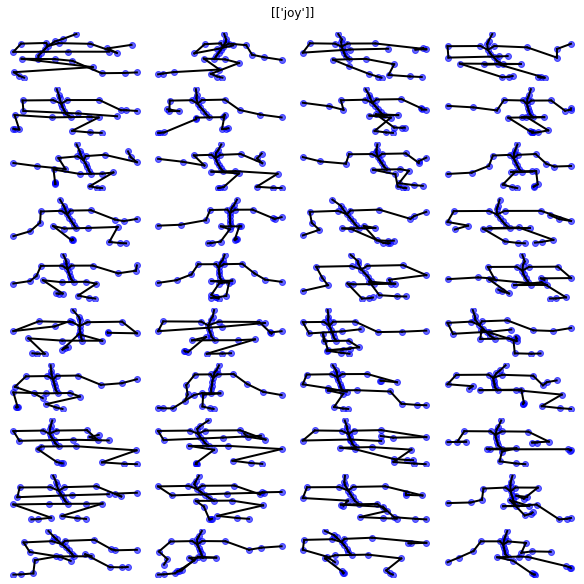

In [191]:
save_checkpoint(generator, dataset, '/content/')

In [139]:
discriminator.train_on_batch([X_real, labels_real], y_real)

[0.6995420455932617, 0.328125]

In [115]:
seq = np.ones((5,200,69))
np.concatenate([seq, np.zeros((seq.shape[0], seq.shape[1], 3))], axis=2)

array([[[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]],

    

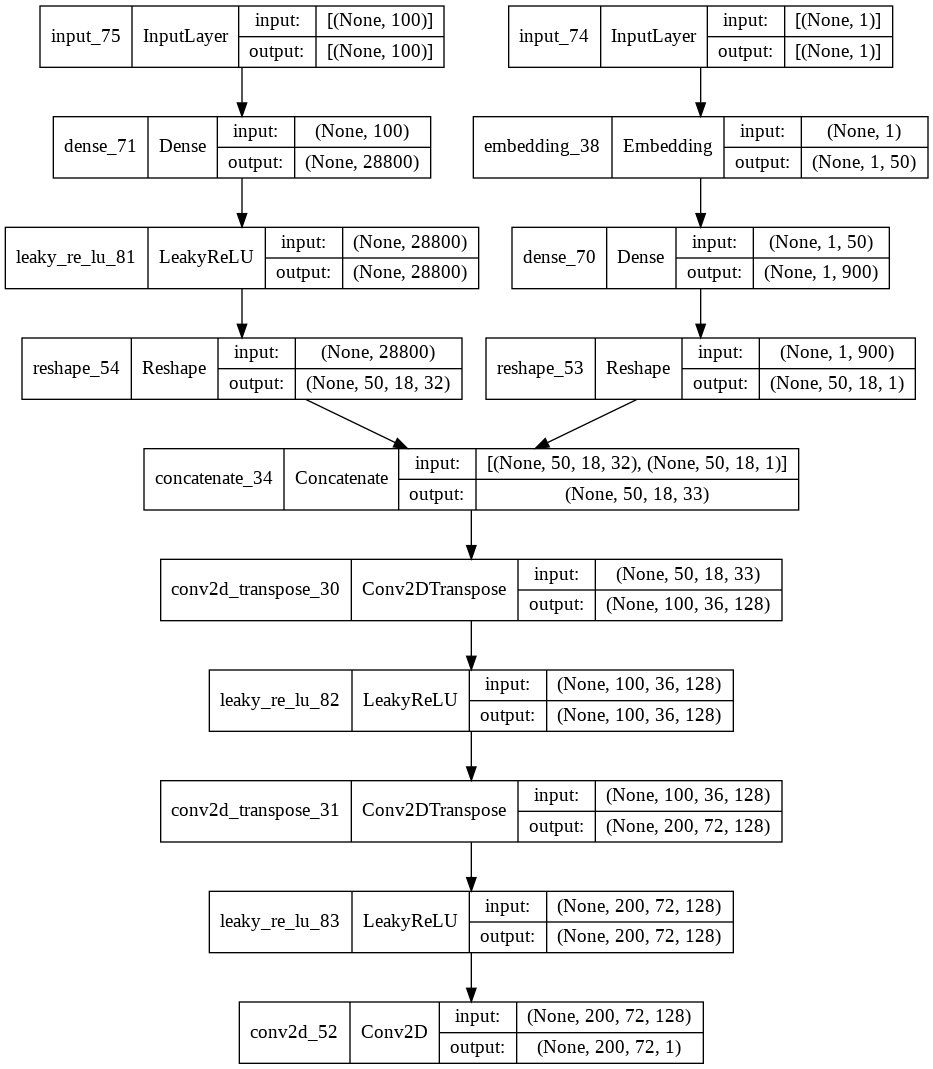

In [103]:
plot_model(generator, show_shapes=True, show_layer_names=True)

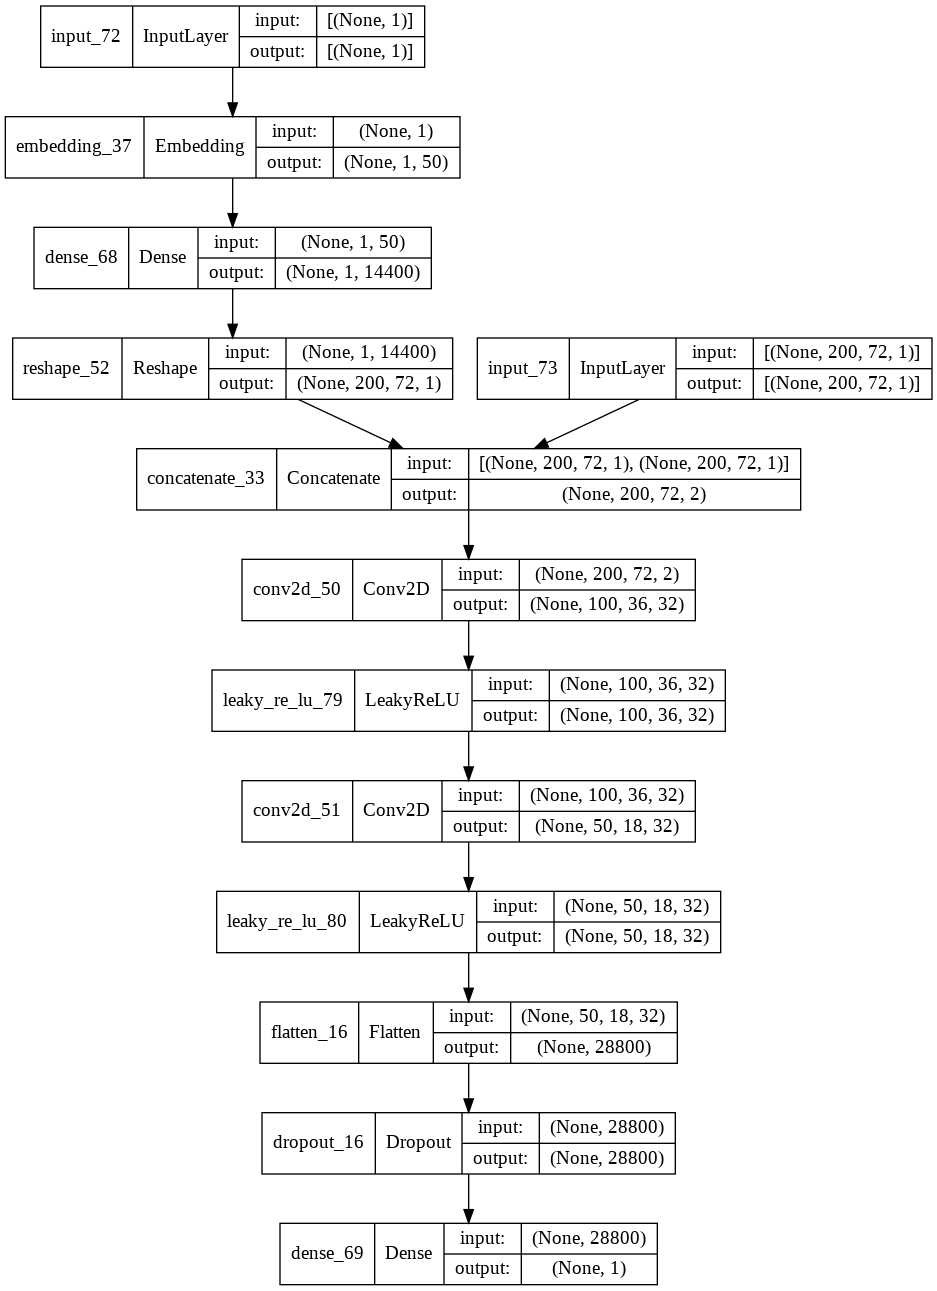

In [100]:
plot_model(discriminator, show_shapes=True, show_layer_names=True)

In [149]:

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, 1/33, d1=0.674, d2=0.696 g=0.692
>1, 2/33, d1=0.623, d2=0.697 g=0.691


KeyboardInterrupt: ignored